In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import Xception
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


In [2]:
(train_X, train_Y), (test_X, test_Y) = fashion_mnist.load_data()

train_X = np.stack((train_X,) * 3, axis=-1)
test_X = np.stack((test_X,) * 3, axis=-1)
train_X.shape, test_X.shape



4422102/4422102 [==============================] - 1s 0us/step


((60000, 28, 28, 3), (10000, 28, 28, 3))

In [3]:
train_X = train_X.reshape(train_X.shape[0], 28, 28, 3)
test_X= test_X.reshape(test_X.shape[0], 28, 28, 3)
train_X.shape, test_X.shape



((60000, 28, 28, 3), (10000, 28, 28, 3))

In [4]:
train_X = np.array([np.array(Image.fromarray(img).resize((71,71), resample=Image.BILINEAR)) for img in train_X])
test_X = np.array([np.array(Image.fromarray(img).resize((71,71), resample=Image.BILINEAR)) for img in test_X])

train_X.shape, test_X.shape

((60000, 71, 71, 3), (10000, 71, 71, 3))

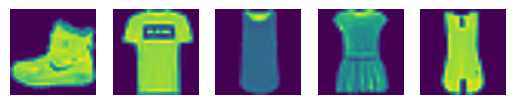

In [5]:
for i in range(5):
    # create a subplot for each object
    plt.subplot(1, 5, i+1)
    # display the object as an image
    plt.imshow(train_X[i][:,:,0])
    # turn off the axis labels and ticks
    plt.axis('off')

# show the plot
plt.show()

In [6]:

# Load the Xception model
base_model = Xception(include_top=False, input_shape=(71,71,3))

from tensorflow import keras

x = keras.layers.Flatten()(base_model.output)
x = keras.layers.Dense(256, activation='relu')(x)
predictions = keras.layers.Dense(10, activation='softmax')(x)


model = keras.models.Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


83683744/83683744 [==============================] - 4s 0us/step


In [7]:
y = model.fit(train_X, train_Y, epochs=3, validation_data=(test_X, test_Y))

# Evaluate the model on the test set
score = model.evaluate(test_X, test_Y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/3
1875/1875 [==============================] - 61s 26ms/step - loss: 2.3092 - accuracy: 0.6557 - val_loss: 0.7470 - val_accuracy: 0.6895
Epoch 2/3
1875/1875 [==============================] - 49s 26ms/step - loss: 0.7038 - accuracy: 0.7257 - val_loss: 0.7695 - val_accuracy: 0.7191
Epoch 3/3
1875/1875 [==============================] - 50s 27ms/step - loss: 0.6338 - accuracy: 0.7673 - val_loss: 0.6726 - val_accuracy: 0.7702
Test loss: 0.6725693941116333
Test accuracy: 0.7702000141143799


In [8]:
from keras.layers import concatenate
import tensorflow as tf

img_a_in = tf.keras.layers.Input(shape = train_X.shape[1:], name = 'ImageA_Input')
img_b_in = tf.keras.layers.Input(shape = train_X.shape[1:], name = 'ImageB_Input')

img_a_feat = model(img_a_in)
img_b_feat = model(img_b_in)

features = concatenate([img_a_feat, img_b_feat], name = 'features')
features = tf.keras.layers.Dense(16, activation='relu')(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.layers.Activation('relu')(features)
features = tf.keras.layers.Dense(4, activation='relu')(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.layers.Activation('relu')(features)
features = tf.keras.layers.Dense(1, activation='sigmoid')(features)

siamese_model = tf.keras.models.Model(inputs = [img_a_feat, img_b_feat], outputs = [features], name = 'Siamese_model')
siamese_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['mae'])
siamese_model.summary()

Model: "Siamese_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 features (Concatenate)         (None, 20)           0           ['input_2[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 16)           336         ['features[1][0]']   

In [9]:
train_groups = [train_X[np.where(train_Y==i)[0]] for i in np.unique(train_Y)]
test_groups = [test_X[np.where(test_Y==i)[0]] for i in np.unique(train_Y)]

In [10]:
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]
test groups: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


In [11]:
def gen_random_batch(in_groups, batch_halfsize = 8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size = batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1] * batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i != c_idx]) for c_idx in group_idx]
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize

        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

1/1 [==============================] - 0s 95ms/step


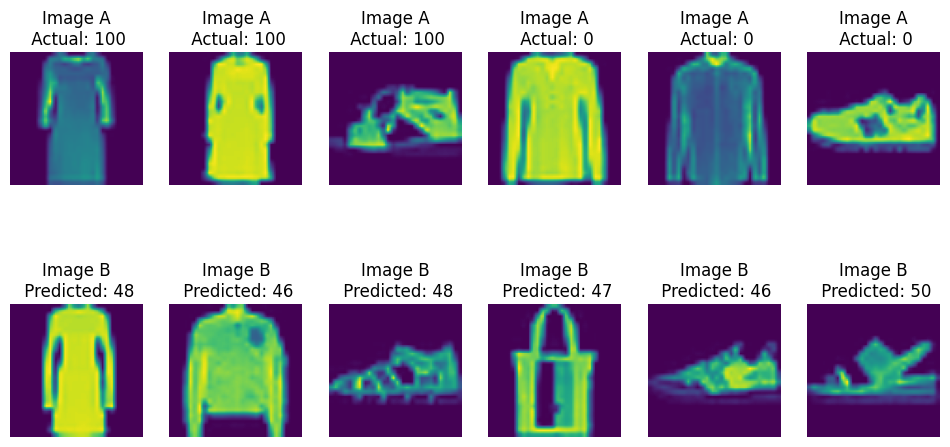

In [12]:
def show_model_output(nb_examples = 3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = siamese_model.predict([model.predict(pv_a), model.predict(pv_b)])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:,:,0])
        ax1.set_title(f'Image A\n Actual: { 100 * c_d }')
        ax1.axis('off')
        ax2.imshow(c_b[:,:,0])
        ax2.set_title(f'Image B\n Predicted: {int( 100 * p_d[0] )}')
        ax2.axis('off')
    return fig
# a completely untrained model
_ = show_model_output()

In [13]:
def siam_gen(in_groups, batch_size = 32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(in_groups, batch_size//2)
        yield [model.predict(pv_a), model.predict(pv_b)], pv_sim

valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = siamese_model.fit(siam_gen(train_groups),
    steps_per_epoch = 500,
    validation_data=([model.predict(valid_a), model.predict(valid_b)],
    valid_sim),
    epochs = 2,
    verbose = True)

1/1 [==============================] - 0s 21ms/step
Epoch 1/2
500/500 [==============================] - 113s 220ms/step - loss: 0.5698 - mae: 0.4078 - val_loss: 0.4548 - val_mae: 0.3316
Epoch 2/2
500/500 [==============================] - 114s 229ms/step - loss: 0.3773 - mae: 0.2661 - val_loss: 0.3241 - val_mae: 0.2147


1/1 [==============================] - 0s 18ms/step


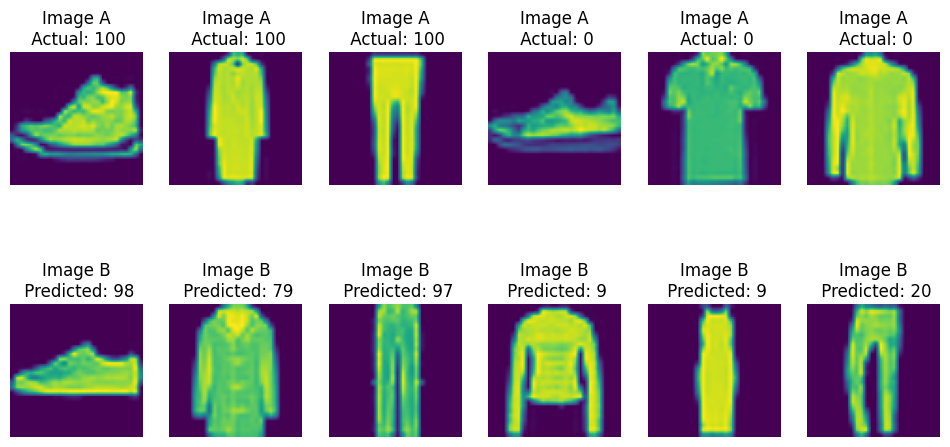

In [18]:
_ = show_model_output()

In [15]:
%%time
from sklearn.manifold import TSNE
x_test_features = model.predict(test_X, verbose = True, batch_size=128)

tsne_obj = TSNE(n_components=2,
    init='pca',
    random_state=101,
    method='barnes_hut',
    n_iter=500,
    verbose=1)
tsne_features = tsne_obj.fit_transform(x_test_features)

79/79 [==============================] - 6s 62ms/step
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.010s...
[t-SNE] Computed neighbors for 10000 samples in 0.413s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.187195
[t-SNE] KL divergence aft

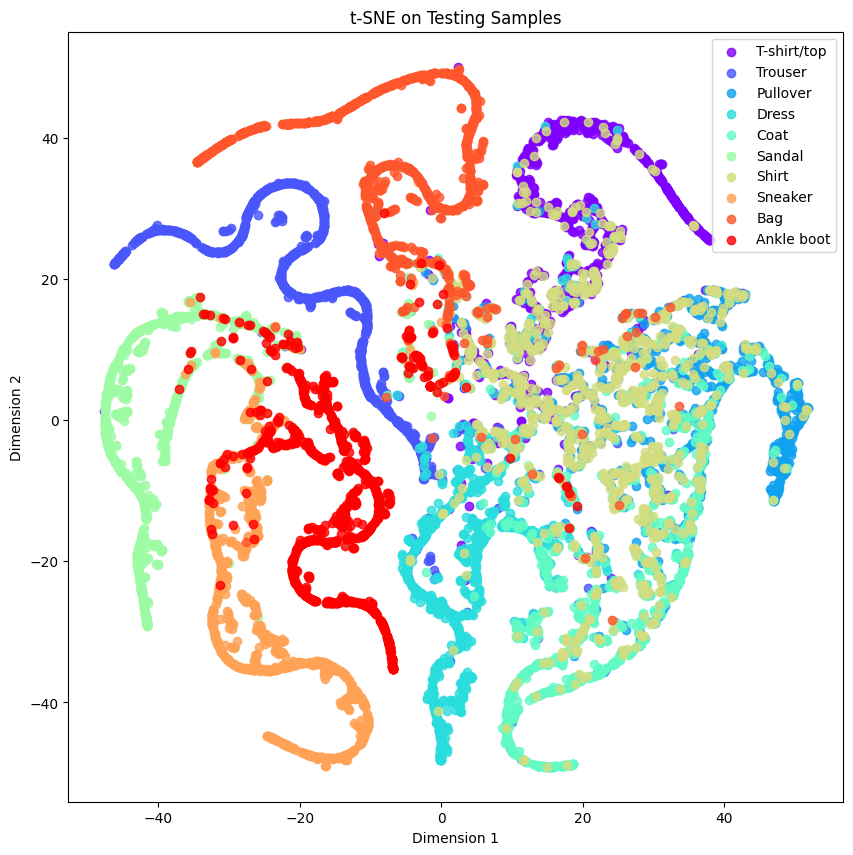

In [16]:
obj_categories = [  
                    'T-shirt/top','Trouser','Pullover','Dress',
                    'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
                 ]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(tsne_features[np.where(test_Y == c_group), 0],
        tsne_features[np.where(test_Y == c_group), 1],
        marker='o',
        color=c_color,
        linewidth=1,
        alpha=0.8,
        label=c_label)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)